In [1]:
import shutil, os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import matplotlib.pyplot as plt
import numpy as np
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset

reprocess_results=True
dataset_name = "ext_test"
dpi=120

In [2]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working.yaml')
#really low iou for nms in order to separate out lesions
cfg.merge_from_list(["MODEL.WEIGHTS", "output_valid_"+ dataset_name + "/model_final.pth",
                     "OUTPUT_DIR", "output_valid_"+ dataset_name + "/results"])
# cfg.merge_from_list(["OUTPUT_DIR", "output_"+ dataset_name])
# print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)
print(cfg.OUTPUT_DIR)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

output_valid_test/model_final.pth
output_valid_test/results


In [3]:
for name in [dataset_name]:
    try:
        DatasetCatalog.register(name, grab_dataset(name))
    except:
        print('Already registered.')
        #do nothing
    MetadataCatalog.get(name).thing_classes = ["rpd"]

In [5]:
if reprocess_results:
    #build model
    from detectron2.modeling import build_model
    model = build_model(cfg)  # returns a torch.nn.Module
    from detectron2.checkpoint import DetectionCheckpointer
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS);  # load a file, usually from cfg.MODEL.WEIGHTS
    model.eval(); #set model in evaluation mode

    from detectron2.data import build_detection_test_loader
    myloader = build_detection_test_loader(cfg,dataset_name)

    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5)
    from detectron2.evaluation import inference_on_dataset
    results_i = inference_on_dataset(model, myloader, myeval)
else:
    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
    myeval.evaluate()

%precision 3
import json
with open(os.path.join(cfg.OUTPUT_DIR,'scalar_dict_'+dataset_name+'.json'),"w") as outfile:
    json.dump(myeval.summarize_scalars(),outfile)

myeval.summarize_scalars()

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.616
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.423
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0

{'dataset': 'test',
 'precision': 0.631,
 'recall': 0.710,
 'fpr': 0.049,
 'iou': 0.200,
 'probability': 0.500}

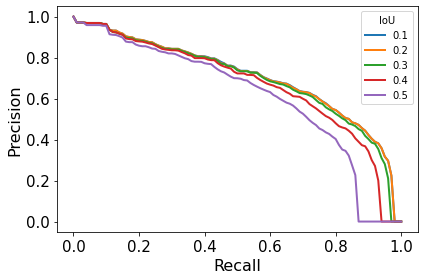

In [19]:

myeval.plot_PRcurve()
plt.tight_layout()
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'PRCurve_'+dataset_name+'.png'),dpi=dpi)


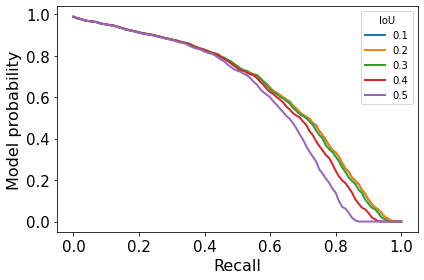

In [20]:

myeval.plot_recall_vs_prob()
plt.tight_layout()
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'ProbvsRecall_'+dataset_name+'.png'),dpi=dpi)

In [8]:

from plain_train_net import CreatePlotsRPD
RPDplt = CreatePlotsRPD.initfromcoco(myeval.mycoco,myeval.prob_thresh)

Precision = [0.526 0.667 0.833 0.833 0.833 0.833 0.833 0.833 0.833 0.833 1.    0.9
 0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9  ]
 Recall = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 FPR = [0.3   0.167 0.067 0.067 0.067 0.067 0.067 0.067 0.067 0.067 0.    0.032
 0.032 0.032 0.032 0.032 0.032 0.032 0.032 0.032]



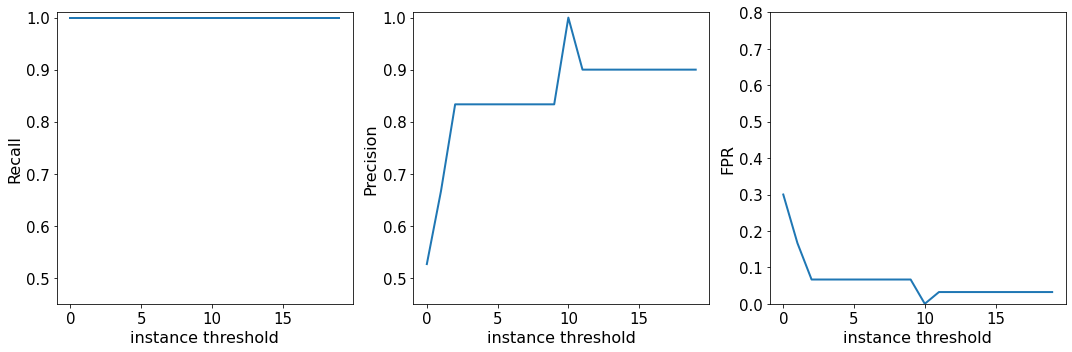

In [9]:
inst = list(range(0,20))
pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(RPDplt.dfpts,inst)
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'instance_thresh_eye_level_'+dataset_name+'.png'),dpi=dpi)
print('Precision = {}\n Recall = {}\n FPR = {}\n'.format(pr,rc,fpr))

In [10]:
RPDplt.dfimg.to_csv(os.path.join(cfg.OUTPUT_DIR,'dfimg_'+dataset_name+'.csv'))
RPDplt.dfpts.to_csv(os.path.join(cfg.OUTPUT_DIR,'dfpts_'+dataset_name+'.csv'))

In [10]:
# inst = list(range(0,6))
# #inst = [4]
# pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(RPDplt.dfimg,inst)
# plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'instance_thresh_scan_level_'+dataset_name+'.png'),dpi=dpi)
# print(pr,rc,fpr)

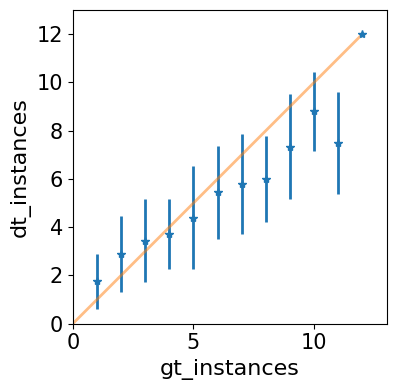

In [11]:
fig = RPDplt.gt_vs_dt_instances()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_instances_'+dataset_name+'.png'),dpi=dpi)

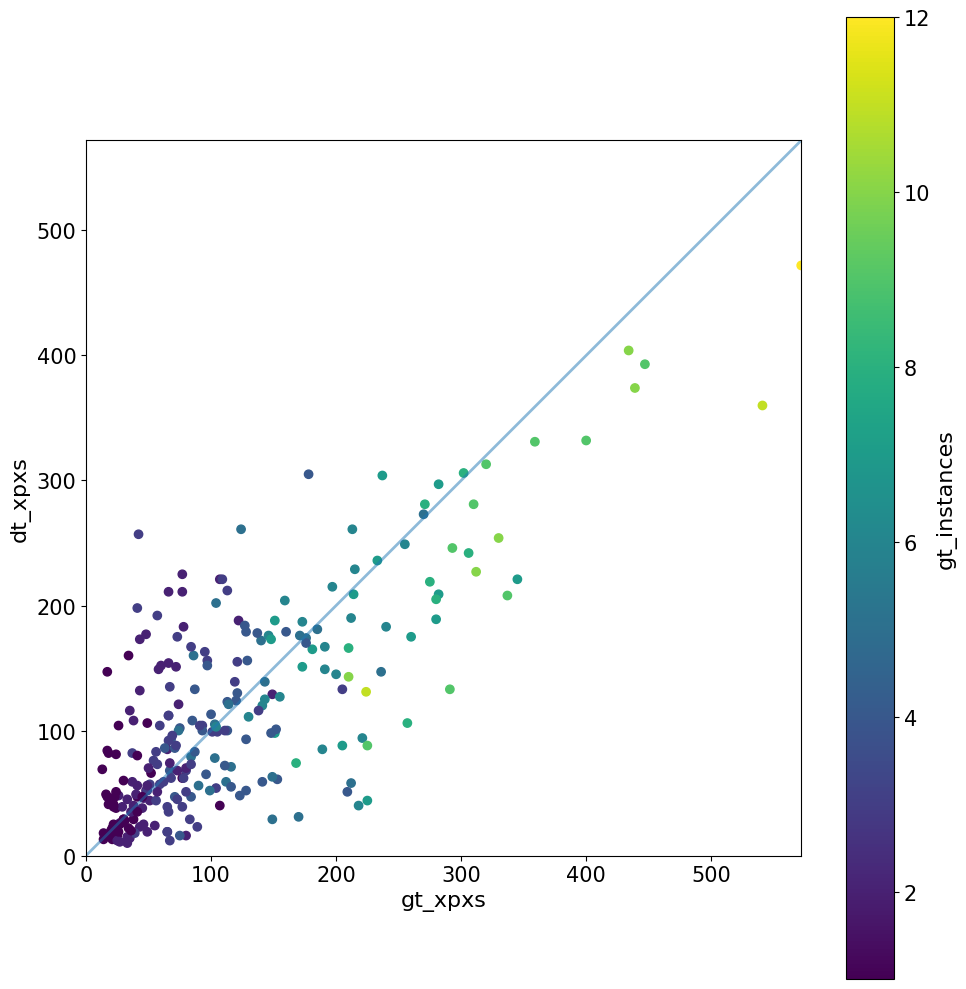

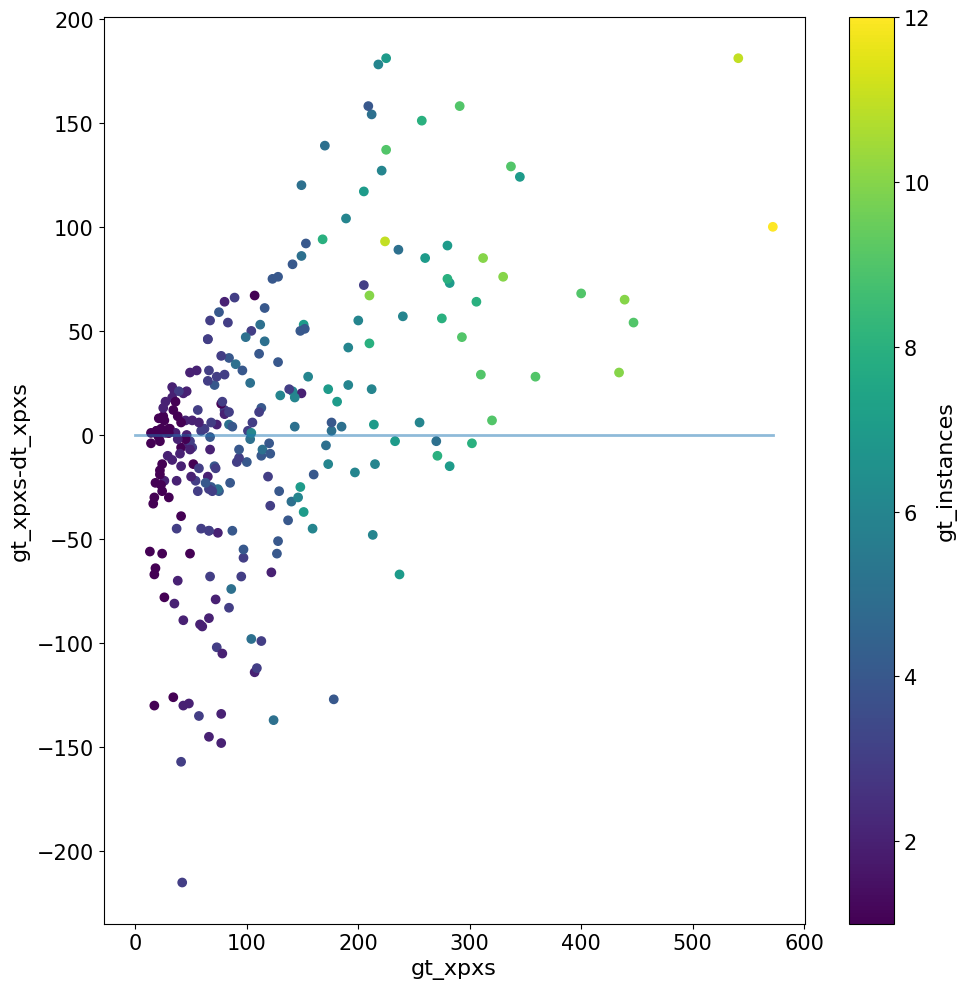

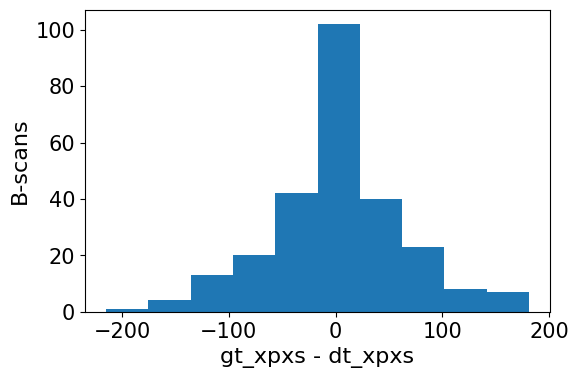

In [12]:
fig1,fig2,fig3 = RPDplt.gt_vs_dt_xpxs()
fig1.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_xpxs_'+dataset_name+'.png'),dpi=dpi)
fig2.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_del_xpxs_'+dataset_name+'.png'),dpi=dpi)

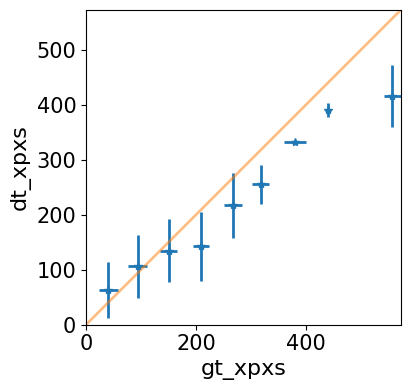

In [13]:
fig = RPDplt.gt_vs_dt_xpxs_mu()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_mu_xpxs_'+dataset_name+'.png'),dpi=dpi)

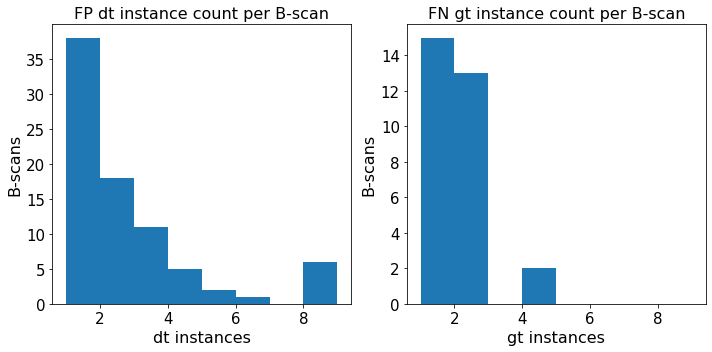

In [14]:
fig = RPDplt.gt_dt_FP_FN_count()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_FP_FN_count_'+dataset_name+'.png'),dpi=dpi)

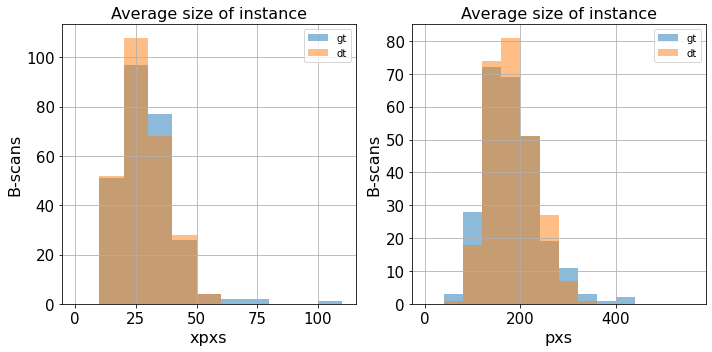

In [15]:
fig = RPDplt.avg_inst_size()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'avg_inst_size_'+dataset_name+'.png'),dpi=dpi)

In [16]:
df = RPDplt.dfimg
from plain_train_net import OutputVis
vis = OutputVis(dataset_name,cfg,0.5)
ImgIds = np.abs(df.gt_instances-df.dt_instances).sort_values(ascending=False).index[0:50].values
vis.output_to_pdf(ImgIds,os.path.join(cfg.OUTPUT_DIR,'top50_instances_err_'+dataset_name+'.pdf'),dfimg =df )

100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


In [16]:
def hover(hover_color="#add8e6"):
    return dict(selector="tbody tr:hover",
            props=[("background-color", "%s" % hover_color)])

styles = [
    #table properties
    dict(selector=" ", 
         props=[("margin","0"),
                ("font-family",'"Helvetica", "Arial", sans-serif'),
                ("border-collapse", "collapse"),
                ("border","none"),
                ("border", "2px solid #ccf")
                   ]),

#     #header color - optional
#     dict(selector="thead", 
#          props=[("background-color","#cc8484")
#                ]),

    #background shading
    dict(selector="tbody tr:nth-child(even)",
         props=[("background-color", "#fff")]),
    dict(selector="tbody tr:nth-child(odd)",
         props=[("background-color", "#eee")]),

    #cell spacing
    dict(selector="td", 
         props=[("padding", ".5em"),("text-align","center")]),

    #header cell properties
    dict(selector="th", 
         props=[("font-size", "125%"),
                ("text-align", "center")]),

    #caption placement
    dict(selector="caption", 
         props=[("caption-side", "bottom")]),

    #render hover last to override background-color
    hover()
]


In [17]:
dfpts = RPDplt.dfpts.sort_values(by=['gt_instances'],ascending=False)
html_str = dfpts.style.format('{:.0f}').set_table_styles(styles).render()
html_file = open(os.path.join(cfg.OUTPUT_DIR,'dfpts_'+dataset_name+'.html'),'w')
html_file.write(html_str)
html_file.close()

In [18]:
dfpts.style.format('{:.0f}').set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

In [18]:
import json, os
import pandas as pd
mydicts=[]
for name in ['fold1','fold2','fold3','fold4','fold5']:
    with open(os.path.join('output_valid_'+name,'results','scalar_dict_'+name+'.json')) as f:
        mydicts.append(json.load(f))
dfr = pd.DataFrame(mydicts)
dfr = dfr.assign(f1 = 2*(dfr.precision*dfr.recall)/(dfr.precision + dfr.recall))
dfr = dfr[['dataset','precision','recall','f1','fpr','iou','probability']]
pd.set_option('display.precision',2)
dfr.style.set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

,dataset,precision,recall,f1,fpr,iou,probability
0,fold1,0.84,0.75,0.79,0.03,0.20,0.50
1,fold2,0.60,0.80,0.68,0.03,0.20,0.50
2,fold3,0.51,0.87,0.64,0.07,0.20,0.50
3,fold4,0.68,0.54,0.60,0.04,0.20,0.50
4,fold5,0.72,0.81,0.76,0.03,0.20,0.50


Index(['Unnamed: 0', 'gt_instances', 'gt_pxs', 'gt_xpxs', 'dt_instances',
       'dt_pxs', 'dt_xpxs', 'ptid', 'eye', 'scan'],
      dtype='object')

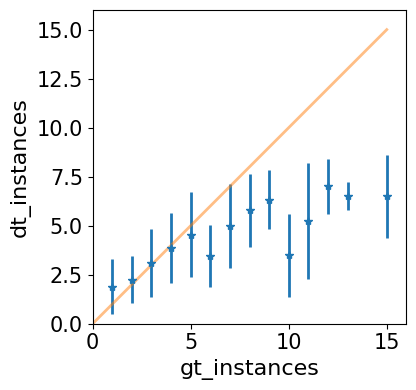

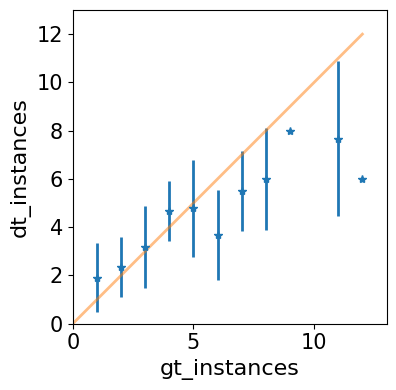

In [26]:
#%%script false --no-raise-error
from plain_train_net import CreatePlotsRPD
RPDplt = CreatePlotsRPD.initfromcsv('output_valid_fold4/results/dfimg_fold4.csv')

RPDplt.gt_vs_dt_instances()

dfimg = RPDplt.dfimg
dfimg_sans_101257 = RPDplt.dfimg[RPDplt.dfimg.ptid != 101257]
dfimg_sans_101106 = RPDplt.dfimg[RPDplt.dfimg.ptid != 101106]
dfimg_sans_101285 = RPDplt.dfimg[RPDplt.dfimg.ptid != 101285]

RPDplt_sans = CreatePlotsRPD(dfimg_sans_101257)
RPDplt_sans.gt_vs_dt_instances();
dfimg_sans_101257.columns

In [27]:
#%%script false --no-raise-error
from plain_train_net import EvaluateClass
import pandas as pd

myeval = EvaluateClass(
    'fold4', 'output_valid_fold4',iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
myeval.evaluate()

def evaluate_on_df(myeval,dfimg):
    myeval.mycoco.params.imgIds=dfimg['Unnamed: 0']
    myeval.mycoco.evaluate()
    myeval.mycoco.accumulate()

    myeval.pr = myeval.mycoco.eval['precision'][:, #iouthresh
                        :, #recall level
                        0, #catagory
                        0, #area range
                        0] #max detections per image
    myeval.rc = myeval.mycoco.params.recThrs
    myeval.iou = myeval.mycoco.params.iouThrs
    myeval.scores = myeval.mycoco.eval['scores'][:,:,0,0,0] #unreliable if GT has no instances
    dd = myeval.summarize_scalars()
    dd['f1'] = (2*dd['precision']*dd['recall'])/(dd['precision']+dd['recall'])
    print(dd)
    return dd


Using previously cached COCO format annotations at 'output_valid_fold4/fold4_coco_format.json'. You need to clear the cache file if your dataset has been modified.


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Calculated metrics for 1960 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.01s).


In [28]:
#%%script false --no-raise-error
from table_styles import styles
pd.set_option('display.precision',2)
dd = evaluate_on_df(myeval,dfimg)
dfscores = pd.DataFrame(dd,index=['original'])
dd = evaluate_on_df(myeval,dfimg_sans_101257)
dfscores = dfscores.append(dd,ignore_index=True)
dd = evaluate_on_df(myeval,dfimg_sans_101106)
dfscores = dfscores.append(dd,ignore_index=True)
dd = evaluate_on_df(myeval,dfimg_sans_101285)
dfscores = dfscores.append(dd,ignore_index=True)
dfscores = dfscores.assign(index=['all data','without_101257','without_101106','without_101285']).set_index('index')
dfscores = dfscores[['dataset','precision','recall','f1','fpr','iou','probability']]
dfscores.style.set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.01s).
{'dataset': 'fold4', 'precision': 0.6789940828402367, 'recall': 0.54, 'fpr': 0.040711009174311925, 'iou': 0.2, 'probability': 0.5, 'f1': 0.601572739187418}
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).
{'dataset': 'fold4', 'precision': 0.6118546845124283, 'recall': 0.64, 'fpr': 0.058486238532110095, 'iou': 0.2, 'probability': 0.5, 'f1': 0.6256109481915934}
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.01s).
{'dataset': 'fold4', 'precision': 0.6234567901234568, 'recall': 0.5, 'fpr': 0.0338302752293578, 'iou': 0.2, 'probability': 0.5, 'f1': 0.5549450549450549}
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.01s).
{'dataset

,dataset,precision,recall,f1,fpr,iou,probability
index,,,,,,,
all data,fold4,0.68,0.54,0.60,0.04,0.20,0.50
without_101257,fold4,0.61,0.64,0.63,0.06,0.20,0.50
without_101106,fold4,0.62,0.50,0.55,0.03,0.20,0.50
without_101285,fold4,0.67,0.51,0.58,0.04,0.20,0.50


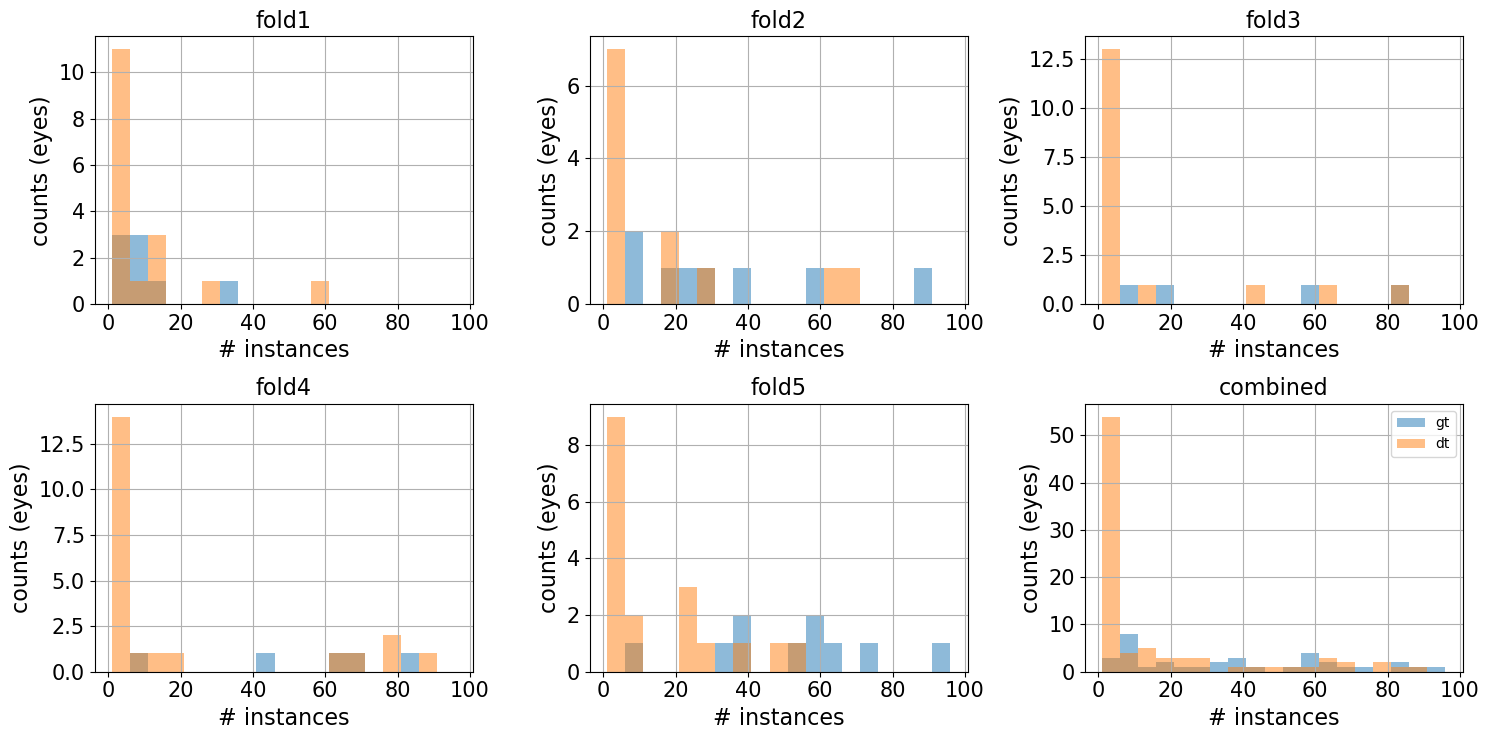

In [4]:
#%%script false --no-raise-error
#Another study looking at instance occurance at the eye level
import json, os
import pandas as pd
df = pd.DataFrame()
fig,ax = plt.subplots(2,3,figsize=[15,7.5],dpi=100)
ax = ax.flatten()
bins = np.arange(1,101,5)
for i, name in enumerate(['fold1','fold2','fold3','fold4','fold5']):
    dffold = pd.read_csv(os.path.join('output_valid_'+name,'results','dfpts_'+name+'.csv'))
    dffold.gt_instances.hist(bins=bins, ax=ax[i],label='gt',alpha=0.5)
    dffold.dt_instances.hist(bins=bins, ax=ax[i],label='dt',alpha=0.5)
    ax[i].set_xlabel('# instances')
    ax[i].set_ylabel('counts (eyes)')
    ax[i].set_title(name)
    df = df.append(dffold.assign(fold = name))
df.gt_instances.hist(bins = bins, ax=ax[5], label='gt',alpha=0.5)
df.dt_instances.hist(bins = bins, ax=ax[5], label='dt',alpha=0.5)
ax[5].set_xlabel('# instances')
ax[5].set_ylabel('counts (eyes)')
ax[5].set_title('combined')
plt.legend()
plt.tight_layout()

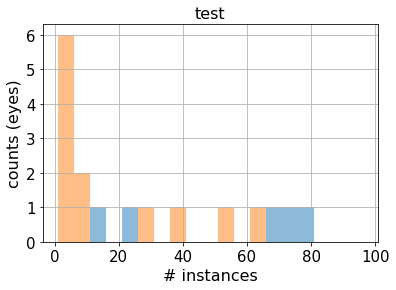

In [5]:
# %%script false --no-raise-error
fig,ax = plt.subplots(1,1)
bins = np.arange(1,101,5)

dffold = pd.read_csv(os.path.join('output_test','dfpts_test.csv'))
dffold.gt_instances.hist(bins=bins, ax=ax,label='gt',alpha=0.5)
dffold.dt_instances.hist(bins=bins, ax=ax,label='dt',alpha=0.5)
ax.set_xlabel('# instances')
ax.set_ylabel('counts (eyes)')
ax.set_title('test')

df = df.append(dffold.assign(fold = 'test'))


In [6]:
#check splits
dfsplits = df[['ptid','fold']].set_index('fold')
splitdict={}
for split in dfsplits.index.drop_duplicates():
    splitdict[split] = set(dfsplits.loc[split,'ptid'])
splitdict
dfcheck = pd.DataFrame(index = splitdict.keys(),columns=splitdict.keys())
for key,value in splitdict.items():
    for key2,value2 in splitdict.items():
        dfcheck.loc[key,key2]= (len(set.intersection(value,value2)))
dfcheck

,fold1,fold2,fold3,fold4,fold5,test
fold1,20,0,0,0,0,0
fold2,0,20,0,0,0,0
fold3,0,0,20,0,0,0
fold4,0,0,0,20,0,0
fold5,0,0,0,0,20,0
test,0,0,0,0,0,20
